In [1640]:
import pandas as pd
%pip install pm4py
import pm4py
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.importer.xes import importer as xes_importer

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

Note: you may need to restart the kernel to use updated packages.


In [1641]:


# Upload log file for domestic declarations
log_domestic = xes_importer.apply("C:/Users/chiar/OneDrive/Desktop/BIS EXAM 2/DomesticDeclarations.xes/DomesticDeclarations.xes")


# Convert the log to a DataFrame
df_domestic = log_converter.apply(log_domestic, variant=log_converter.Variants.TO_DATA_FRAME)


df_domestic['time:timestamp'] = pd.to_datetime(df_domestic['time:timestamp'])
df_domestic['case:concept:name'] = df_domestic['case:concept:name'].astype(str)

#transform amount in float
df_domestic['amount'] = pd.to_numeric(df_domestic['case:Amount'], errors='coerce')

# Verify number of cases and events in the log
print(f"Numero casi domestic: {len(log_domestic)}")
print(f"Numero eventi totali domestic: {sum(len(trace) for trace in log_domestic)}")





parsing log, completed traces :: 100%|██████████| 10500/10500 [00:03<00:00, 3235.81it/s]


Numero casi domestic: 10500
Numero eventi totali domestic: 56437


In [1642]:
# Sort by case ID and timestamp domestic
df_domestic = df_domestic.sort_values(by=['case:concept:name', 'time:timestamp'])

# Get start and end activities for each case
start_activities = pm4py.get_start_activities(df_domestic)
end_activities = pm4py.get_end_activities(df_domestic)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'Declaration SUBMITTED by EMPLOYEE': 10365, 'Declaration SAVED by EMPLOYEE': 135}
End activities: {'Payment Handled': 10043, 'Declaration REJECTED by EMPLOYEE': 284, 'Declaration REJECTED by ADMINISTRATION': 5, 'Declaration SAVED by EMPLOYEE': 134, 'Declaration REJECTED by SUPERVISOR': 4, 'Declaration REJECTED by MISSING': 30}


In [1643]:
#filter domestic by start and end activities
filtered_domestic_log = pm4py.filter_start_activities(log_domestic, 
                                                      ['Declaration SUBMITTED by EMPLOYEE'])
filtered_domestic_log = pm4py.filter_end_activities(filtered_domestic_log,
                                                    ['Payment Handled', 'Declaration REJECTED by EMPLOYEE', 
                                                     'Declaration REJECTED by ADMINISTRATION', 'Declaration REJECTED by SUPERVISOR',
                                                       ] )

print(f"Numero casi: {len(filtered_domestic_log)}")
filtered_domestic_log

#convert filtered log to DataFrame
filtered_domestic_df = log_converter.apply(filtered_domestic_log, variant=log_converter.Variants.TO_DATA_FRAME)

filtered_domestic_df


Numero casi: 10335


,id,org:resource,concept:name,time:timestamp,org:role,case:id,case:concept:name,case:BudgetNumber,case:DeclarationNumber,case:Amount
0,st_step 86794_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 09:49:50+00:00,EMPLOYEE,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
1,st_step 86793_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2017-01-09 11:27:48+00:00,SUPERVISOR,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
2,dd_declaration 86791_19,SYSTEM,Request Payment,2017-01-10 09:34:44+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
3,dd_declaration 86791_20,SYSTEM,Payment Handled,2017-01-12 17:31:22+00:00,UNDEFINED,declaration 86791,declaration 86791,budget 86566,declaration number 86792,26.851205
4,st_step 86798_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-09 10:26:14+00:00,EMPLOYEE,declaration 86795,declaration 86795,budget 86566,declaration number 86796,182.464172
...,...,...,...,...,...,...,...,...,...,...
56193,st_step 138363_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2018-12-29 17:50:14+00:00,EMPLOYEE,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56194,st_step 138361_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-12-29 17:56:13+00:00,ADMINISTRATION,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56195,st_step 138362_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2019-01-03 08:55:52+00:00,SUPERVISOR,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576
56196,dd_declaration 138359_19,SYSTEM,Request Payment,2019-01-08 08:20:28+00:00,UNDEFINED,declaration 138359,declaration 138359,budget 86566,declaration number 138360,190.404576


In [1644]:
#FIND CASES WITH ZERO DURATION
zero_duration_cases = []
for trace in filtered_domestic_log:
    if len(trace) < 2:
        continue
    start = trace[0]['time:timestamp']
    end = trace[-1]['time:timestamp']
    if (end - start).total_seconds() <= 0:
        zero_duration_cases.append(trace.attributes['concept:name'])

print(f"Casi con durata ≤ 0: {len(zero_duration_cases)}")



Casi con durata ≤ 0: 0


In [1645]:
#CHECK FOR NAN VALUES
# Define columns of interest
columns_to_check = [
    'id', 'org:resource', 'concept:name', 'time:timestamp', 'org:role',
    'case:id', 'case:concept:name', 'case:BudgetNumber',
    'case:DeclarationNumber', 'case:Amount'
]

# Check for missing values
missing_values = df_domestic[columns_to_check].isnull().sum()

# Print only the columns where NaNs are found
print(missing_values[missing_values > 0])

print(f"Number of original cases: {len(log_domestic)}")
print(f"Number of cases now: {len(filtered_domestic_df)}")



Series([], dtype: int64)
Number of original cases: 10500
Number of cases now: 56198


In [1646]:
#Preliminary statistics on the domestic log
# Number of activities per case: average and median
case_activity_counts = filtered_domestic_df.groupby("case:concept:name").size()
avg_activities_per_case = case_activity_counts.mean()
median_activities_per_case = case_activity_counts.median()

# Lead time per case: time difference between first and last activity
lead_times = filtered_domestic_df.groupby("case:concept:name")["time:timestamp"].agg(lambda x: (x.max() - x.min()).total_seconds())
avg_lead_time_days = lead_times.mean() / 86400  # days conversion
median_lead_time_days = lead_times.median() / 86400 

# Results
print(f"Mean of number of activities per case: {avg_activities_per_case:.2f}")
print(f"Median of number of activities per case: {median_activities_per_case:.2f}")
print(f"Mean lead time for case: {avg_lead_time_days:.2f} days")
print(f"Median lead time for case: {median_lead_time_days:.2f} days")

Mean of number of activities per case: 5.44
Median of number of activities per case: 5.00
Mean lead time for case: 11.67 days
Median lead time for case: 7.35 days


Mean of number of activities per case: 5.44
Median of number of activities per case: 5.00


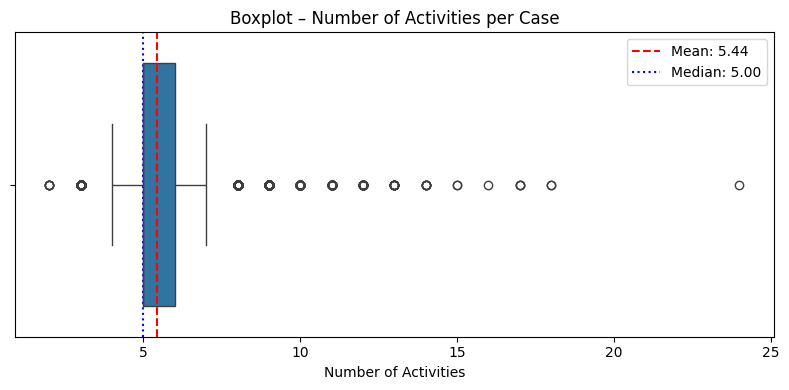

In [1647]:
# Number of activities per case: average and median
case_activity_counts = filtered_domestic_df.groupby("case:concept:name").size()


media = case_activity_counts.mean()
mediana = case_activity_counts.median()

print(f"Mean of number of activities per case: {media:.2f}")
print(f"Median of number of activities per case: {mediana:.2f}")

# Boxplot of number of activities per case
plt.figure(figsize=(8, 4))
sns.boxplot(x=case_activity_counts)
plt.title("Boxplot – Number of Activities per Case")
plt.xlabel("Number of Activities")

# Annotations
plt.axvline(media, color='red', linestyle='--', label=f'Mean: {media:.2f}')
plt.axvline(mediana, color='blue', linestyle=':', label=f'Median: {mediana:.2f}')
plt.legend()

plt.tight_layout()
plt.show()

In [1648]:
case_activity_counts = filtered_domestic_df.groupby("case:concept:name").size()

# Step 2: Test di normalità (Shapiro-Wilk)
# NB: massimo 500 osservazioni per Shapiro → si usa un campione casuale se necessario
sample = case_activity_counts
if len(case_activity_counts) > 500:
    sample = case_activity_counts.sample(500, random_state=42)

shapiro_stat, shapiro_p = stats.shapiro(sample)
print(f"Test Shapiro-Wilk p-value: {shapiro_p:.5f}")
if shapiro_p < 0.05:
    print("Distribution is not normal(p < 0.05)")
else:
    print("The distribution is normal (p ≥ 0.05)")




Test Shapiro-Wilk p-value: 0.00000
Distribution is not normal(p < 0.05)


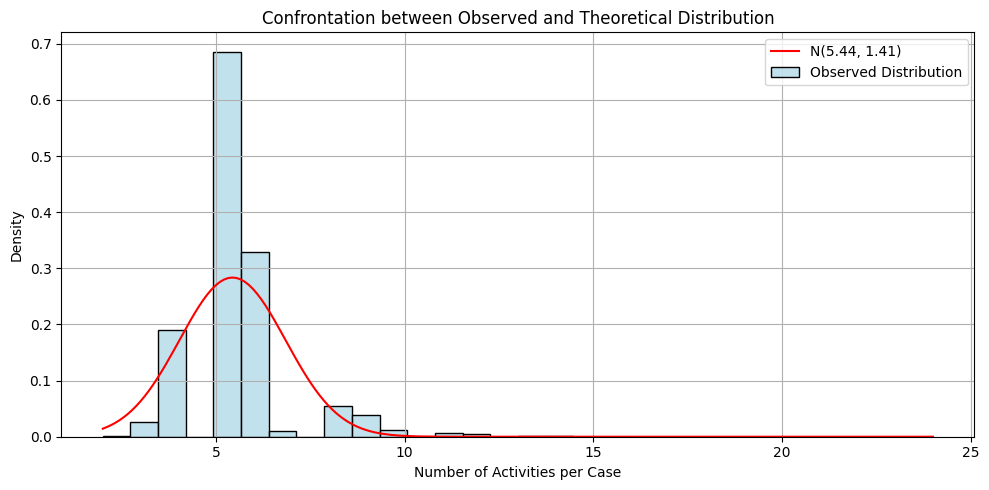

In [1649]:
#Density graph
mu = case_activity_counts.mean()
sigma = case_activity_counts.std()
from scipy.stats import norm

plt.figure(figsize=(10, 5))

# Istogramma della distribuzione osservata, normalizzato
sns.histplot(case_activity_counts, stat="density", bins=30, kde=False, color="lightblue", label="Observed Distribution")

# X per la curva teorica
x = np.linspace(case_activity_counts.min(), case_activity_counts.max(), 200)
gaussian_pdf = norm.pdf(x, mu, sigma)

# Curva della distribuzione normale teorica
plt.plot(x, gaussian_pdf, color='red', label=f'N({mu:.2f}, {sigma:.2f})')

plt.title("Confrontation between Observed and Theoretical Distribution")
plt.xlabel("Number of Activities per Case")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1650]:
boot_means = []
for _ in range(1000):
    sample = case_activity_counts.sample(frac=1, replace=True)
    boot_means.append(np.mean(sample))

ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)

print(f"Mean observed: {np.mean(case_activity_counts):.2f}")
print(f"Confidence Interval (95%): [{ci_lower:.2f}, {ci_upper:.2f}]")


Mean observed: 5.44
Confidence Interval (95%): [5.41, 5.47]


In [1651]:
#IQR for number of activities per case
q1_act = case_activity_counts.quantile(0.25)
q3_act = case_activity_counts.quantile(0.75)
iqr_act = q3_act - q1_act
lower_bound_act = q1_act - 1.5 * iqr_act
upper_bound_act = q3_act + 1.5 * iqr_act
outliers_act = case_activity_counts[(case_activity_counts < lower_bound_act) | (case_activity_counts > upper_bound_act)]
n_outliers_act = len(outliers_act)

#total cases
total_cases = len(case_activity_counts)

# Percentage of outliers
perc_outliers_act = n_outliers_act / total_cases * 100


print(f"Number of outliers: {n_outliers_act} casi ({perc_outliers_act:.2f}%)")



Number of outliers: 1125 casi (10.89%)


In [1652]:
from pm4py.objects.log.util import filtering_utils
from pm4py.objects.log.obj import EventLog
# Get ids of outlier cases
outlier_ids_act = set(outliers_act.index)

# remove corresponding traces from the filtered log
filtered_domestic_log = [trace for trace in filtered_domestic_log
                                         if trace.attributes["concept:name"] not in outlier_ids_act]




#convert in event log
filtered_domestic_log = EventLog(filtered_domestic_log)

#and back to DataFrame
filtered_domestic_df = log_converter.apply(filtered_domestic_log,variant=log_converter.Variants.TO_DATA_FRAME)

# Verify
print(f"Number of original cases: {len(log_domestic)}")
print(f"Number of cases after filtering out outliers: {len(filtered_domestic_log)}")


Number of original cases: 10500
Number of cases after filtering out outliers: 9210


Mean Lead time: 10.52 giorni
Median Lead time: 7.28 giorni


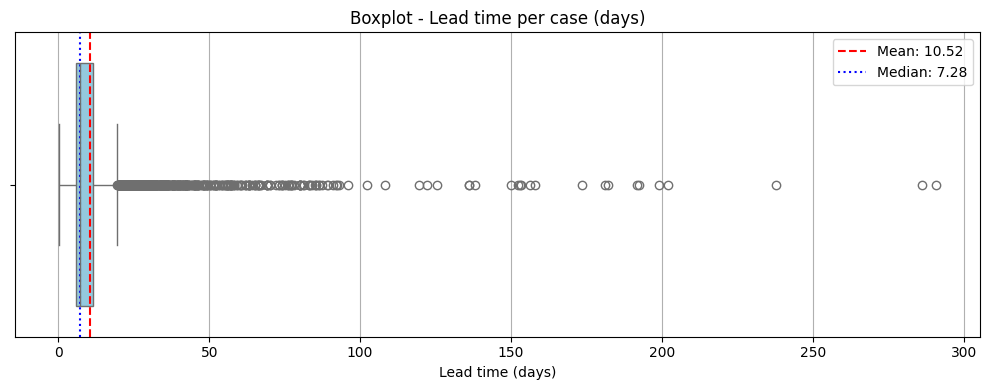

In [1653]:
# Lead time per case
lead_times = filtered_domestic_df.groupby("case:concept:name")["time:timestamp"].agg(lambda x: (x.max() - x.min()).total_seconds())
avg_lead_time_days = lead_times.mean() / 86400  # days conversion
median_lead_time_days = lead_times.median() / 86400  

print(f"Mean Lead time: {avg_lead_time_days:.2f} giorni")
print(f"Median Lead time: {median_lead_time_days:.2f} giorni")

# Convert lead times to days
lead_time_days = lead_times / 86400

# Boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=lead_time_days, color='skyblue')
plt.title("Boxplot - Lead time per case (days)")
plt.xlabel("Lead time (days)")
plt.grid(True, axis='x')

# Annotations
plt.axvline(avg_lead_time_days, color='red', linestyle='--', label=f'Mean: {avg_lead_time_days:.2f}')
plt.axvline(median_lead_time_days, color='blue', linestyle=':', label=f'Median: {median_lead_time_days:.2f}')
plt.legend()

plt.tight_layout()
plt.show()


In [1654]:
# Normality Test (Shapiro-Wilk)

sample = lead_time_days
if len(lead_time_days) > 500:
    sample = lead_time_days.sample(500, random_state=42)

shapiro_stat, shapiro_p = stats.shapiro(sample)
print(f"Test di Shapiro-Wilk – p-value: {shapiro_p:.5f}")
if shapiro_p < 0.05:
    print("La distribuzione NON è normale (p < 0.05)")
else:
    print("La distribuzione è compatibile con la normalità (p ≥ 0.05)")



Test di Shapiro-Wilk – p-value: 0.00000
La distribuzione NON è normale (p < 0.05)


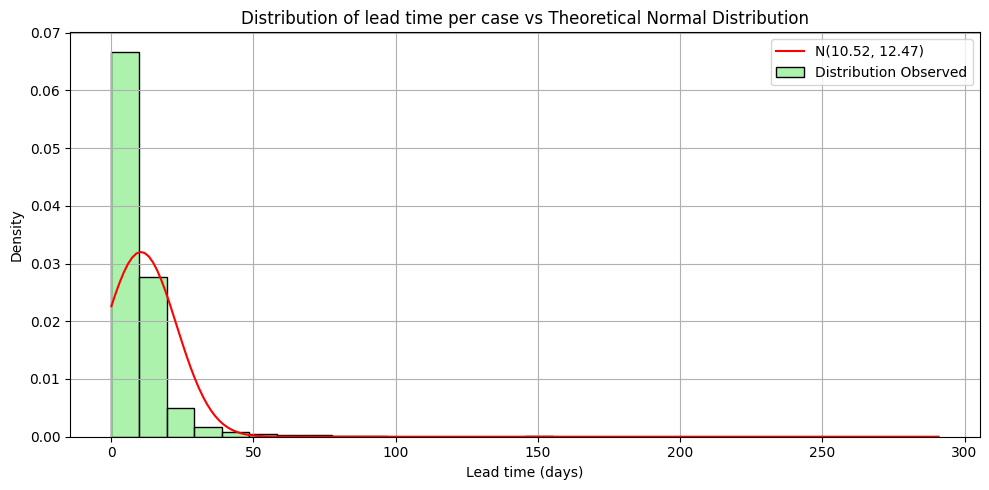

In [1655]:


# get mean and standard deviation for lead time
mu_lt = lead_time_days.mean()
sigma_lt = lead_time_days.std()

# plot
plt.figure(figsize=(10, 5))

# Histogram of observed distribution (normalized)
sns.histplot(lead_time_days, stat="density", bins=30, kde=False, color="lightgreen", label="Distribution Observed")


# Curve of the theoretical normal distribution
x = np.linspace(lead_time_days.min(), lead_time_days.max(), 200)
plt.plot(x, norm.pdf(x, mu_lt, sigma_lt), color='red', label=f'N({mu_lt:.2f}, {sigma_lt:.2f})')

#Labes
plt.title("Distribution of lead time per case vs Theoretical Normal Distribution")
plt.xlabel("Lead time (days)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1656]:

#Outlier per (lead time)
lead_time_days = lead_times / 86400
q1_lt = lead_time_days.quantile(0.25)
q3_lt = lead_time_days.quantile(0.75)
iqr_lt = q3_lt - q1_lt
lower_bound_lt = q1_lt - 1.5 * iqr_lt
upper_bound_lt = q3_lt + 1.5 * iqr_lt
outliers_lt = lead_time_days[(lead_time_days < lower_bound_lt) | (lead_time_days > upper_bound_lt)]
n_outliers_lt = len(outliers_lt)

# total cases
total_cases = len(lead_time_days)

# Percentage of outliers

perc_outliers_lt = n_outliers_lt / total_cases * 100

print(total_cases)


print(f"Outlier per durata (lunghi o brevi): {n_outliers_lt} casi ({perc_outliers_lt:.2f}%)")


9210
Outlier per durata (lunghi o brevi): 793 casi (8.61%)


In [1657]:
#filter out outliers from filtered_domestic_log
outlier_ids_lt = set(outliers_lt.index)

from pm4py.objects.log.obj import EventLog

# Fiter traces that are not outliers
filtered_domestic_log = [trace for trace in filtered_domestic_log 
                                        if trace.attributes["concept:name"] not in outlier_ids_lt]

# Convert to EventLog
filtered_domestic_log= EventLog(filtered_domestic_log)

# Verifica
print(f"Number of cases after removing outliers on duration: {len(filtered_domestic_log)}")

# Convert to DataFrame
filtered_domestic_df = log_converter.apply(
    filtered_domestic_log, 
    variant=log_converter.Variants.TO_DATA_FRAME
)



Number of cases after removing outliers on duration: 8417


In [1658]:
# INTERNATIONAL LOG

In [1659]:
# Log for international declarations
log_international = xes_importer.apply("C:/Users/chiar/OneDrive/Desktop/BIS EXAM 2/InternationalDeclarations.xes/InternationalDeclarations.xes")


# Convert to DataFrame
df_international = log_converter.apply(log_international, variant=log_converter.Variants.TO_DATA_FRAME)


df_international['time:timestamp'] = pd.to_datetime(df_international['time:timestamp'])
df_international['case:concept:name'] = df_international['case:concept:name'].astype(str)


df_international['amount'] = pd.to_numeric(df_international['case:Amount'], errors='coerce')

# Verify number of cases and events in the log
print(f"Number of cases: {len(log_international)}")
print(f"Number of events: {sum(len(trace) for trace in log_international)}")





parsing log, completed traces :: 100%|██████████| 6449/6449 [00:02<00:00, 2824.62it/s]


Number of cases: 6449
Number of events: 72151


In [1660]:
# Sort by case ID and timestamp international
df_international = df_international.sort_values(by=['case:concept:name', 'time:timestamp'])

# Get start and end activities for each case
start_activities = pm4py.get_start_activities(df_international)
end_activities = pm4py.get_end_activities(df_international)
print("Start activities: {}\nEnd activities: {}".format(start_activities, end_activities))

Start activities: {'Permit SUBMITTED by EMPLOYEE': 5294, 'Start trip': 740, 'Declaration SUBMITTED by EMPLOYEE': 407, 'Declaration SAVED by EMPLOYEE': 8}
End activities: {'Payment Handled': 5646, 'End trip': 593, 'Declaration REJECTED by EMPLOYEE': 130, 'Declaration SAVED by EMPLOYEE': 54, 'Send Reminder': 2, 'Request Payment': 3, 'Declaration REJECTED by SUPERVISOR': 1, 'Declaration REJECTED by MISSING': 11, 'Permit REJECTED by MISSING': 8, 'Declaration FINAL_APPROVED by SUPERVISOR': 1}


In [1661]:
#filter international by start and end activities
filtered_internat_log = pm4py.filter_start_activities(log_international, 
                                                      ['Permit SUBMITTED by EMPLOYEE'])
filtered_internat_log = pm4py.filter_end_activities(filtered_internat_log,
                                                    ['Payment Handled', 
                                                     'Declaration REJECTED by EMPLOYEE', 'Declaration REJECTED by SUPERVISOR',
                                                       ] )

print(f"Number of cases: {len(filtered_internat_log)}")
filtered_internat_log

#convert filtered log to DataFrame
filtered_internat_df = log_converter.apply(filtered_internat_log, variant=log_converter.Variants.TO_DATA_FRAME)

filtered_internat_df


Number of cases: 5126


,id,org:resource,concept:name,time:timestamp,org:role,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,case:Permit TaskNumber,...,case:concept:name,case:Permit OrganizationalEntity,case:travel permit number,case:Permit RequestedBudget,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount
0,st_step 72820_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2017-01-09 11:21:03+00:00,EMPLOYEE,travel permit number 72816,declaration number 72818,614.080529,614.080529,task 427,...,declaration 72817,organizational unit 65458,travel permit number 72816,1015.978607,declaration 72817,travel permit 72815,travel permit 72815,budget 143506,UNKNOWN,614.080529
1,st_step 72819_0,STAFF MEMBER,Permit FINAL_APPROVED by SUPERVISOR,2017-01-09 11:21:22+00:00,SUPERVISOR,travel permit number 72816,declaration number 72818,614.080529,614.080529,task 427,...,declaration 72817,organizational unit 65458,travel permit number 72816,1015.978607,declaration 72817,travel permit 72815,travel permit 72815,budget 143506,UNKNOWN,614.080529
2,rv_travel permit 72815_6,STAFF MEMBER,Start trip,2017-01-16 00:00:00+00:00,EMPLOYEE,travel permit number 72816,declaration number 72818,614.080529,614.080529,task 427,...,declaration 72817,organizational unit 65458,travel permit number 72816,1015.978607,declaration 72817,travel permit 72815,travel permit 72815,budget 143506,UNKNOWN,614.080529
3,rv_travel permit 72815_7,STAFF MEMBER,End trip,2017-01-19 00:00:00+00:00,EMPLOYEE,travel permit number 72816,declaration number 72818,614.080529,614.080529,task 427,...,declaration 72817,organizational unit 65458,travel permit number 72816,1015.978607,declaration 72817,travel permit 72815,travel permit 72815,budget 143506,UNKNOWN,614.080529
4,st_step 72823_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-30 13:56:18+00:00,EMPLOYEE,travel permit number 72816,declaration number 72818,614.080529,614.080529,task 427,...,declaration 72817,organizational unit 65458,travel permit number 72816,1015.978607,declaration 72817,travel permit 72815,travel permit 72815,budget 143506,UNKNOWN,614.080529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59009,st_step 13465_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-12-21 11:49:19+00:00,ADMINISTRATION,travel permit number 13457,declaration number 13459,445.064943,445.064943,task 427,...,declaration 13458,organizational unit 65456,travel permit number 13457,527.032565,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943
59010,st_step 13464_0,STAFF MEMBER,Declaration APPROVED by BUDGET OWNER,2019-01-14 14:47:27+00:00,BUDGET OWNER,travel permit number 13457,declaration number 13459,445.064943,445.064943,task 427,...,declaration 13458,organizational unit 65456,travel permit number 13457,527.032565,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943
59011,st_step 13467_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2019-01-21 05:15:11+00:00,SUPERVISOR,travel permit number 13457,declaration number 13459,445.064943,445.064943,task 427,...,declaration 13458,organizational unit 65456,travel permit number 13457,527.032565,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943
59012,fd_declaration 13458_17,SYSTEM,Request Payment,2019-01-22 09:49:01+00:00,UNDEFINED,travel permit number 13457,declaration number 13459,445.064943,445.064943,task 427,...,declaration 13458,organizational unit 65456,travel permit number 13457,527.032565,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943


In [1662]:
threshold = 0.1

cases_to_remove = filtered_internat_df[
    (filtered_internat_df['case:Amount'].abs() < threshold) |
    (filtered_internat_df['case:RequestedAmount'].abs() < threshold) |
    (filtered_internat_df['case:AdjustedAmount'].abs() < threshold)
]['case:concept:name'].unique()

# Remove cases with amounts close to zero
filtered_internat_df = filtered_internat_df[~filtered_internat_df['case:concept:name'].isin(cases_to_remove)]

# Output final
print(f"Removed {len(cases_to_remove)} cases with amounts ≈ 0")
print(f"Cases remaining: {filtered_internat_df['case:concept:name'].nunique()}")





filtered_internat_df

Removed 125 cases with amounts ≈ 0
Cases remaining: 5001


,id,org:resource,concept:name,time:timestamp,org:role,case:Permit travel permit number,case:DeclarationNumber,case:Amount,case:RequestedAmount,case:Permit TaskNumber,...,case:concept:name,case:Permit OrganizationalEntity,case:travel permit number,case:Permit RequestedBudget,case:id,case:Permit ID,case:Permit id,case:BudgetNumber,case:Permit ActivityNumber,case:AdjustedAmount
0,st_step 72820_0,STAFF MEMBER,Permit SUBMITTED by EMPLOYEE,2017-01-09 11:21:03+00:00,EMPLOYEE,travel permit number 72816,declaration number 72818,614.080529,614.080529,task 427,...,declaration 72817,organizational unit 65458,travel permit number 72816,1015.978607,declaration 72817,travel permit 72815,travel permit 72815,budget 143506,UNKNOWN,614.080529
1,st_step 72819_0,STAFF MEMBER,Permit FINAL_APPROVED by SUPERVISOR,2017-01-09 11:21:22+00:00,SUPERVISOR,travel permit number 72816,declaration number 72818,614.080529,614.080529,task 427,...,declaration 72817,organizational unit 65458,travel permit number 72816,1015.978607,declaration 72817,travel permit 72815,travel permit 72815,budget 143506,UNKNOWN,614.080529
2,rv_travel permit 72815_6,STAFF MEMBER,Start trip,2017-01-16 00:00:00+00:00,EMPLOYEE,travel permit number 72816,declaration number 72818,614.080529,614.080529,task 427,...,declaration 72817,organizational unit 65458,travel permit number 72816,1015.978607,declaration 72817,travel permit 72815,travel permit 72815,budget 143506,UNKNOWN,614.080529
3,rv_travel permit 72815_7,STAFF MEMBER,End trip,2017-01-19 00:00:00+00:00,EMPLOYEE,travel permit number 72816,declaration number 72818,614.080529,614.080529,task 427,...,declaration 72817,organizational unit 65458,travel permit number 72816,1015.978607,declaration 72817,travel permit 72815,travel permit 72815,budget 143506,UNKNOWN,614.080529
4,st_step 72823_0,STAFF MEMBER,Declaration SUBMITTED by EMPLOYEE,2017-01-30 13:56:18+00:00,EMPLOYEE,travel permit number 72816,declaration number 72818,614.080529,614.080529,task 427,...,declaration 72817,organizational unit 65458,travel permit number 72816,1015.978607,declaration 72817,travel permit 72815,travel permit 72815,budget 143506,UNKNOWN,614.080529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59009,st_step 13465_0,STAFF MEMBER,Declaration APPROVED by ADMINISTRATION,2018-12-21 11:49:19+00:00,ADMINISTRATION,travel permit number 13457,declaration number 13459,445.064943,445.064943,task 427,...,declaration 13458,organizational unit 65456,travel permit number 13457,527.032565,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943
59010,st_step 13464_0,STAFF MEMBER,Declaration APPROVED by BUDGET OWNER,2019-01-14 14:47:27+00:00,BUDGET OWNER,travel permit number 13457,declaration number 13459,445.064943,445.064943,task 427,...,declaration 13458,organizational unit 65456,travel permit number 13457,527.032565,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943
59011,st_step 13467_0,STAFF MEMBER,Declaration FINAL_APPROVED by SUPERVISOR,2019-01-21 05:15:11+00:00,SUPERVISOR,travel permit number 13457,declaration number 13459,445.064943,445.064943,task 427,...,declaration 13458,organizational unit 65456,travel permit number 13457,527.032565,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943
59012,fd_declaration 13458_17,SYSTEM,Request Payment,2019-01-22 09:49:01+00:00,UNDEFINED,travel permit number 13457,declaration number 13459,445.064943,445.064943,task 427,...,declaration 13458,organizational unit 65456,travel permit number 13457,527.032565,declaration 13458,travel permit 13456,travel permit 13456,budget 147525,UNKNOWN,445.064943


In [1663]:
#already did 
# Domestic – Identifica e rimuovi i casi con amount 0
zero_amount_domestic_ids = filtered_domestic_df[
    filtered_domestic_df["case:Amount"] == 0
]["case:concept:name"].unique()

print(f"❌ Casi con importo = 0 nel log Domestic: {len(zero_amount_domestic_ids)} ({len(zero_amount_domestic_ids)/filtered_domestic_df['case:concept:name'].nunique()*100:.2f}%)")

filtered_domestic_df = filtered_domestic_df[
    ~filtered_domestic_df["case:concept:name"].isin(zero_amount_domestic_ids)
]

# International – Identifica e rimuovi i casi con amount 0
zero_amount_international_ids = filtered_internat_df[
    filtered_internat_df["case:Amount"] == 0
]["case:concept:name"].unique()

print(f"❌ Casi con importo = 0 nel log International: {len(zero_amount_international_ids)} ({len(zero_amount_international_ids)/truncated_internat_df['case:concept:name'].nunique()*100:.2f}%)")

filtered_internat_df = filtered_internat_df[
    ~filtered_internat_df["case:concept:name"].isin(zero_amount_international_ids)
]


❌ Casi con importo = 0 nel log Domestic: 63 (0.75%)
❌ Casi con importo = 0 nel log International: 0 (0.00%)


In [1664]:
# Filter activities starting with "Permit"
permit_activities = filtered_internat_df["concept:name"]
permit_counts = permit_activities[permit_activities.str.startswith("Permit")].value_counts()

print(permit_counts)

concept:name
Permit SUBMITTED by EMPLOYEE           5171
Permit FINAL_APPROVED by SUPERVISOR    4487
Permit APPROVED by ADMINISTRATION      3979
Permit APPROVED by BUDGET OWNER        1445
Permit APPROVED by SUPERVISOR           534
Permit FINAL_APPROVED by DIRECTOR       534
Permit APPROVED by PRE_APPROVER         467
Permit REJECTED by EMPLOYEE             149
Permit REJECTED by SUPERVISOR            67
Permit REJECTED by ADMINISTRATION        38
Permit REJECTED by MISSING               33
Permit REJECTED by BUDGET OWNER          25
Permit REJECTED by PRE_APPROVER          20
Name: count, dtype: int64


In [1665]:
#find only cases with "Permit FINAL_APPROVED by SUPERVISOR"
approval_activities = [
    'Permit FINAL_APPROVED by SUPERVISOR',
]

#find cases with approval activities
cases_with_approval = filtered_internat_df[
    filtered_internat_df['concept:name'].isin(approval_activities)
]['case:concept:name'].unique()

#Find id of cases without approval activities
all_case_ids = filtered_internat_df['case:concept:name'].unique()
cases_without_approval = set(all_case_ids) - set(cases_with_approval)

print(f"Cases with no approved permit: {len(cases_without_approval)}")
if len(cases_without_approval) == 0:
    print("There are no cases without approved permits.")
   

#Remove cases without approval from the DataFrame
filtered_internat_df = filtered_internat_df[~filtered_internat_df['case:concept:name'].isin(cases_without_approval)]
#print(f"Casi rimanenti dopo la rimozione: {filtered_internat_df['case:concept:name'].nunique()}")

Cases with no approved permit: 528


In [1666]:

approval_activity = "Permit FINAL_APPROVED by SUPERVISOR"

# Lista dei case ID da escludere
violating_cases = []

# scan each case
for case_id, group in filtered_internat_df.groupby("case:concept:name"):
    group_sorted = group.sort_values("time:timestamp")

    # find time of approval activity
    approval_events = group_sorted[group_sorted["concept:name"] == approval_activity]
    if approval_events.empty:
        continue  

    approval_time = approval_events["time:timestamp"].iloc[0]

    # find time of "Start trip" activity
    start_trip_events = group_sorted[group_sorted["concept:name"] == "Start trip"]
    if start_trip_events.empty:
        continue  # nessun inizio viaggio

    start_trip_time = start_trip_events["time:timestamp"].iloc[0]

    # Verify if "Start trip" is before approval
    if start_trip_time < approval_time:
        violating_cases.append(case_id)

# show how many cases violate the rule
print(f"Cases with 'Start trip' BEFORE '{approval_activity}': {len(violating_cases)}")

# remove violating cases from the DataFrame
filtered_internat_df = filtered_internat_df[~filtered_internat_df["case:concept:name"].isin(violating_cases)]

# Verifiy
#print(f"✅ Casi rimanenti nel log dopo la rimozione: {filtered_internat_df['case:concept:name'].nunique()}")

Cases with 'Start trip' BEFORE 'Permit FINAL_APPROVED by SUPERVISOR': 357


In [1667]:
#Crop cases so that they start from activity "Declaration SUBMITTED by EMPLOYEE"
# create a list to store truncated cases
truncated_events = []


for case_id, group in filtered_internat_df.groupby("case:concept:name"):
    group_sorted = group.sort_values("time:timestamp")

    mask = group_sorted["concept:name"] == "Declaration SUBMITTED by EMPLOYEE"
    if not mask.any():
        continue  # if declaration not present, skip the case 

    start_index = mask.idxmax()  # index of the first occurrence of the activity
    truncated_group = group_sorted.loc[start_index:] 

    truncated_events.append(truncated_group)

# all cropped cases in DataFrame
truncated_internat_df = pd.concat(truncated_events)
#transform to event log
truncated_internat_log = log_converter.apply(truncated_internat_df, variant=log_converter.Variants.TO_EVENT_LOG)

# Verify
print(f"Number of cases cropped: {truncated_internat_df['case:concept:name'].nunique()}")


Number of cases cropped: 4116


Mean Activities per case: 6.11 giorni
Median Activities per case: 5.00 giorni


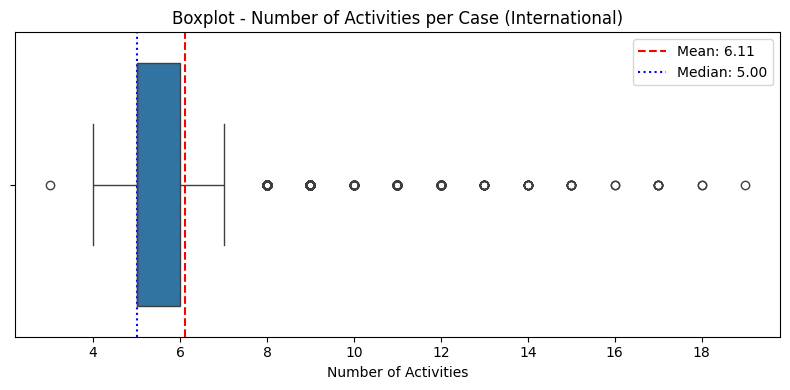

In [1668]:
# How many activities per case
activity_counts_internat = truncated_internat_df.groupby("case:concept:name").size()

mean_activities = activity_counts_internat.mean()
median_activities = activity_counts_internat.median()

print(f"Mean Activities per case: {mean_activities:.2f} giorni")
print(f"Median Activities per case: {median_activities:.2f} giorni")

# Boxplot of number of activities per case
plt.figure(figsize=(8, 4))
sns.boxplot(x=activity_counts_internat)
plt.title("Boxplot - Number of Activities per Case (International)")
plt.xlabel("Number of Activities")

# Annotazioni
plt.axvline(mean_activities, color='red', linestyle='--', label=f'Mean: {mean_activities:.2f}')
plt.axvline(median_activities, color='blue', linestyle=':', label=f'Median: {median_activities:.2f}')
plt.legend()

plt.tight_layout()
plt.show()


In [1669]:
# Normalty Test (Shapiro-Wilk)
sample = activity_counts_internat
if len(activity_counts_internat) > 500:
    sample = activity_counts_internat.sample(500, random_state=42)

shapiro_stat, shapiro_p = stats.shapiro(sample)
print(f"📊 Test di Shapiro-Wilk – p-value: {shapiro_p:.5f}")
if shapiro_p < 0.05:
    print("Distribution is NOT normal (p < 0.05)")
else:
    print("Distribution is normal (p ≥ 0.05)")

📊 Test di Shapiro-Wilk – p-value: 0.00000
Distribution is NOT normal (p < 0.05)


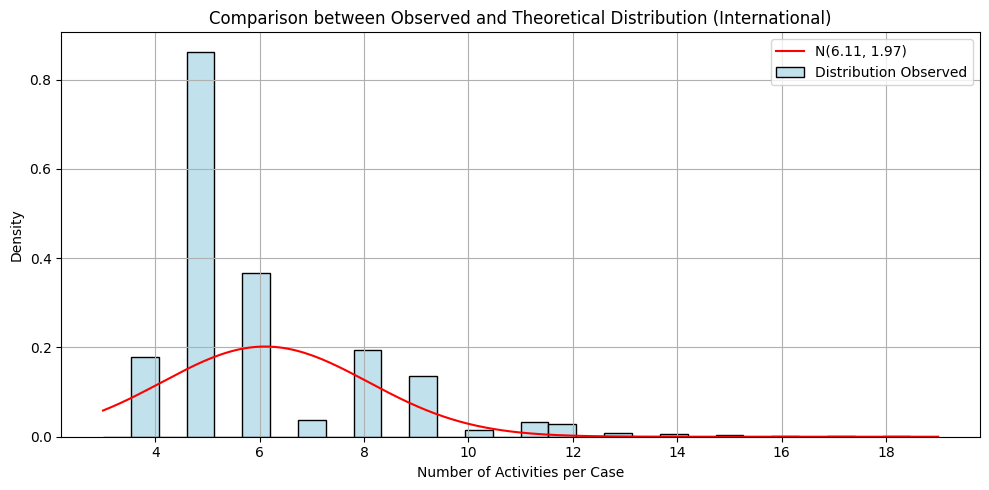

In [1670]:
#Density graph
mu = activity_counts_internat.mean()
sigma = activity_counts_internat.std()
from scipy.stats import norm

plt.figure(figsize=(10, 5))

# histogram of observed distribution, normalized
sns.histplot(activity_counts_internat, stat="density", bins=30, kde=False, color="lightblue", label="Distribution Observed")

# X for the theoretical curve
x = np.linspace(activity_counts_internat.min(), activity_counts_internat.max(), 200)
gaussian_pdf = norm.pdf(x, mu, sigma)

# curve of the theoretical normal distribution
plt.plot(x, gaussian_pdf, color='red', label=f'N({mu:.2f}, {sigma:.2f})')

plt.title("Comparison between Observed and Theoretical Distribution (International)")
plt.xlabel("Number of Activities per Case")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [1671]:
boot_means = []
for _ in range(1000):
    sample = activity_counts_internat.sample(frac=1, replace=True)
    boot_means.append(np.mean(sample))

ci_lower = np.percentile(boot_means, 2.5)
ci_upper = np.percentile(boot_means, 97.5)

print(f"Mean Observed: {np.mean(activity_counts_internat):.2f}")
print(f"Confidence Interval (95%): [{ci_lower:.2f}, {ci_upper:.2f}]")


Mean Observed: 6.11
Confidence Interval (95%): [6.04, 6.16]


In [1672]:
# IQR for number of activities per case
q1_act = activity_counts_internat.quantile(0.25)
q3_act = activity_counts_internat.quantile(0.75)
iqr_act = q3_act - q1_act
lower_bound_act = q1_act - 2 * iqr_act
upper_bound_act = q3_act + 2 * iqr_act
outliers_act_int = activity_counts_internat[(activity_counts_internat < lower_bound_act) | (activity_counts_internat > upper_bound_act)]
n_outliers_act_int = len(outliers_act_int)

print(lower_bound_act, upper_bound_act)
# total cases
total_cases = len(activity_counts_internat)

#percentage of outliers
perc_outliers_act_i = n_outliers_act_int / total_cases * 100


print(f"Outliers per number of activities): {n_outliers_act_int} casi ({perc_outliers_act_i:.2f}%)")



3.0 8.0
Outliers per number of activities): 518 casi (12.59%)


In [1673]:
from pm4py.objects.log.util import filtering_utils
from pm4py.objects.log.obj import EventLog
print(truncated_internat_df['case:concept:name'].nunique())

# Ottieni i case ID outlier
outlier_case_ids = set(outliers_act_int.index)

# Rimuovi i casi outlier dal DataFrame
truncated_internat_df = truncated_internat_df[
    ~truncated_internat_df["case:concept:name"].isin(outlier_case_ids)
]

#rimuovi casi outlier dal log non troncato
filtered_internat_df = filtered_internat_df[
    ~filtered_internat_df["case:concept:name"].isin(outlier_case_ids)
]

print(f"Number of cases after filtering out outliers: {truncated_internat_df['case:concept:name'].nunique()}")







4116
Number of cases after filtering out outliers: 3598


Mean lead time per case: 13.07 days
Meadian lead time per case: 9.39 days


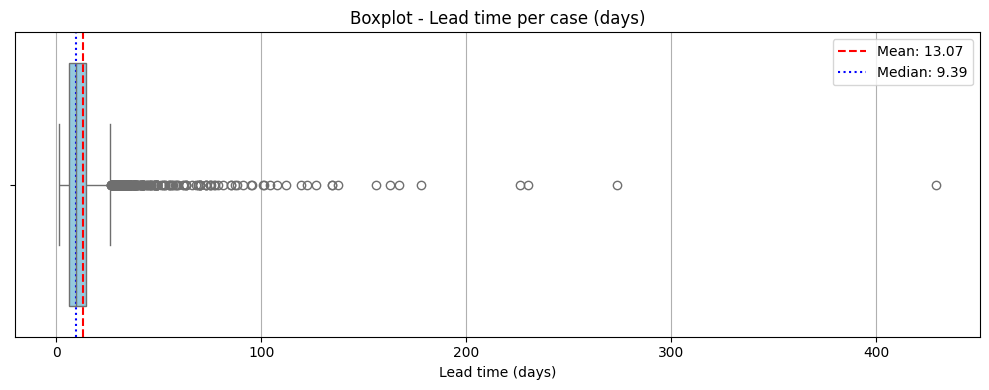

In [1674]:
# Lead time per case
lead_times_i = truncated_internat_df.groupby("case:concept:name")["time:timestamp"].agg(lambda x: (x.max() - x.min()).total_seconds())
avg_lead_time_days_i = lead_times_i.mean() / 86400  # conversione in giorni
median_lead_time_days_i = lead_times_i.median() / 86400  # conversione in giorni

print(f"Mean lead time per case: {avg_lead_time_days_i:.2f} days")
print(f"Meadian lead time per case: {median_lead_time_days_i:.2f} days")

# Converte i secondi in giorni
lead_time_days_i = lead_times_i / 86400

# Visualizza il boxplot
plt.figure(figsize=(10, 4))
sns.boxplot(x=lead_time_days_i, color='skyblue')
plt.title("Boxplot - Lead time per case (days)")
plt.xlabel("Lead time (days)")
plt.grid(True, axis='x')

# Annotazioni per media e mediana
plt.axvline(avg_lead_time_days_i, color='red', linestyle='--', label=f'Mean: {avg_lead_time_days_i:.2f}')
plt.axvline(median_lead_time_days_i, color='blue', linestyle=':', label=f'Median: {median_lead_time_days_i:.2f}')
plt.legend()

plt.tight_layout()
plt.show()


In [1675]:
# Normality Test (Shapiro-Wilk)
sample_i = lead_time_days_i
if len(lead_time_days_i) > 500:
    sample_i = lead_time_days_i.sample(500, random_state=42)

shapiro_stat, shapiro_p = stats.shapiro(sample_i)
print(f"📊 Test di Shapiro-Wilk – p-value: {shapiro_p:.5f}")
if shapiro_p < 0.05:
    print("Distribution is NOT normal (p < 0.05)")
else:
    print("Distribution is normal (p ≥ 0.05)")



📊 Test di Shapiro-Wilk – p-value: 0.00000
Distribution is NOT normal (p < 0.05)


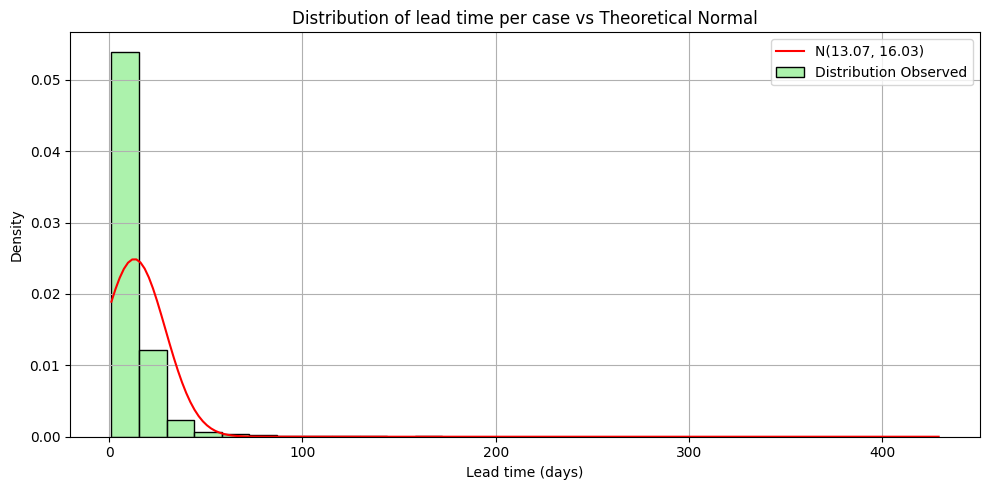

In [1676]:
# mean and standard deviation for lead time
mu_lt = lead_time_days_i.mean()
sigma_lt = lead_time_days_i.std()

#  plot
plt.figure(figsize=(10, 5))

# Histogram of observed distribution (normalized)
sns.histplot(lead_time_days_i, stat="density", bins=30, kde=False, color="lightgreen", label="Distribution Observed")

# KDE opzionale della distribuzione osservata
#sns.kdeplot(lead_time_days_i, color="green", label="KDE osservata")

# curve of the theoretical normal distribution
x = np.linspace(lead_time_days_i.min(), lead_time_days_i.max(), 200)
plt.plot(x, norm.pdf(x, mu_lt, sigma_lt), color='red', label=f'N({mu_lt:.2f}, {sigma_lt:.2f})')

# Etichette e legenda
plt.title("Distribution of lead time per case vs Theoretical Normal")
plt.xlabel("Lead time (days)")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [1677]:
#IQR
#Outliers per (lead time)
lead_time_days_i = lead_times_i / 86400
q1_lt = lead_time_days_i.quantile(0.25)
q3_lt = lead_time_days_i.quantile(0.75)
iqr_lt = q3_lt - q1_lt
lower_bound_lt = q1_lt - 1.5 * iqr_lt
upper_bound_lt = q3_lt + 1.5 * iqr_lt
outliers_lt_i = lead_time_days_i[(lead_time_days_i < lower_bound_lt) | (lead_time_days_i > upper_bound_lt)]
n_outliers_lt_i = len(outliers_lt_i)

# Total cases
total_cases = len(lead_time_days_i)

# Percentage

perc_outliers_lt_i = n_outliers_lt_i / total_cases * 100

print(total_cases)


print(f"Number of outliers per duration: {n_outliers_lt_i} cases ({perc_outliers_lt_i:.2f}%)")


3598
Number of outliers per duration: 280 cases (7.78%)


In [1678]:
#filter out outliers

# Ottieni i case ID outlier
outlier_case_ids_i = set(outliers_lt_i.index)

# Rimuovi i casi outlier dal DataFrame
truncated_internat_df = truncated_internat_df[
    ~truncated_internat_df["case:concept:name"].isin(outlier_case_ids_i)
]

# Rimuovi i casi outlier dal DataFrame non troncato
filtered_internat_df = filtered_internat_df[
    ~filtered_internat_df["case:concept:name"].isin(outlier_case_ids_i)
]

print(f"Number of cases after filtering out outliers: {filtered_internat_df['case:concept:name'].nunique()}")
#print(f"Numero casi dopo rimozione outlier: {truncated_internat_df['case:concept:name'].nunique()}")



Number of cases after filtering out outliers: 3318


In [1679]:
#Amount analisys

#Mean Requested Amount – Domestic
amounts_d = filtered_domestic_df.groupby("case:concept:name")["case:Amount"].first()
mean_amount_d = amounts_d.mean()
print(f"💶 Rimborso medio richiesto - Domestic log: {mean_amount_d:.2f}")

# mean requested amount – International
amounts_i = truncated_internat_df.groupby("case:concept:name")["case:Amount"].first()
mean_amount_i = amounts_i.mean()
print(f"💶 Rimborso medio richiesto – International log: {mean_amount_i:.2f}")

amounts_domestic = filtered_domestic_df.groupby("case:concept:name")["case:Amount"].first().reset_index()
amounts_domestic["Log"] = "Domestic"

amounts_international = truncated_internat_df.groupby("case:concept:name")["case:Amount"].first().reset_index()
amounts_international["Log"] = "International"

# Merge the two DataFrames
df_amounts = pd.concat([amounts_domestic, amounts_international], ignore_index=True)

# Rename the column for clarity
df_amounts.rename(columns={"case:Amount": "Importo Richiesto"}, inplace=True)

💶 Rimborso medio richiesto - Domestic log: 81.45
💶 Rimborso medio richiesto – International log: 673.03


DOMESTIC — Shapiro-Wilk p-value: 0.00000
Distribution is NOT normal (p < 0.05)


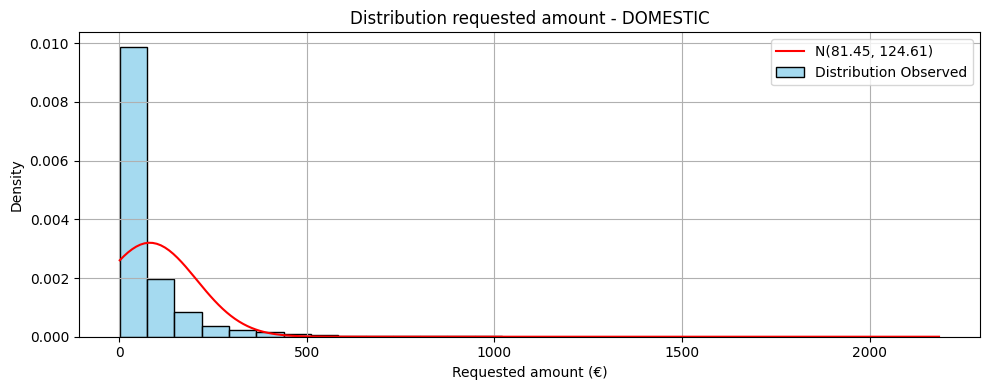

In [1680]:
#NORMALITY TEST DOMESTIC ON AMOUNT
# Shapiro test
sample_d = amounts_d
if len(amounts_d) > 500:
    sample_d = amounts_d.sample(500, random_state=42)

shapiro_stat_d, shapiro_p_d = shapiro(sample_d)
print(f"DOMESTIC — Shapiro-Wilk p-value: {shapiro_p_d:.5f}")
if shapiro_p_d < 0.05:
    print("Distribution is NOT normal (p < 0.05)")
else:
    print("Distribution is normal (p ≥ 0.05)")

# Parameters for the normal distribution
mu_d = amounts_d.mean()
sigma_d = amounts_d.std()

# plot
plt.figure(figsize=(10, 4))
sns.histplot(amounts_d, stat="density", bins=30, color="skyblue", label="Distribution Observed")
x_d = np.linspace(amounts_d.min(), amounts_d.max(), 200)
plt.plot(x_d, norm.pdf(x_d, mu_d, sigma_d), color="red", label=f"N({mu_d:.2f}, {sigma_d:.2f})")
plt.title("Distribution requested amount - DOMESTIC")
plt.xlabel("Requested amount (€)")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [1681]:
# IQR per DOMESTIC
q1_amount_d = amounts_d.quantile(0.25)
q3_amount_d = amounts_d.quantile(0.75)
iqr_amount_d = q3_amount_d - q1_amount_d
lower_d = q1_amount_d - 1.5 * iqr_amount_d
upper_d = q3_amount_d + 1.5 * iqr_amount_d
outliers_d = amounts_d[(amounts_d < lower_d) | (amounts_d > upper_d)]
print(f"📌 DOMESTIC – Outlier Amount: {len(outliers_d)} su {len(amounts_d)} casi")

# Ottieni case ID da rimuovere
outlier_ids_d = set(outliers_d.index)

# Rimuovi outlier da DOMESTIC
filtered_domestic_df = filtered_domestic_df[
    ~filtered_domestic_df["case:concept:name"].isin(outlier_ids_d)
]

print(f"✅ DOMESTIC – Casi rimanenti: {filtered_domestic_df['case:concept:name'].nunique()}")

📌 DOMESTIC – Outlier Amount: 938 su 8354 casi


✅ DOMESTIC – Casi rimanenti: 7416


📊 INTERNATIONAL — Shapiro-Wilk p-value: 0.00000
Distribution is NOT normal(p < 0.05)


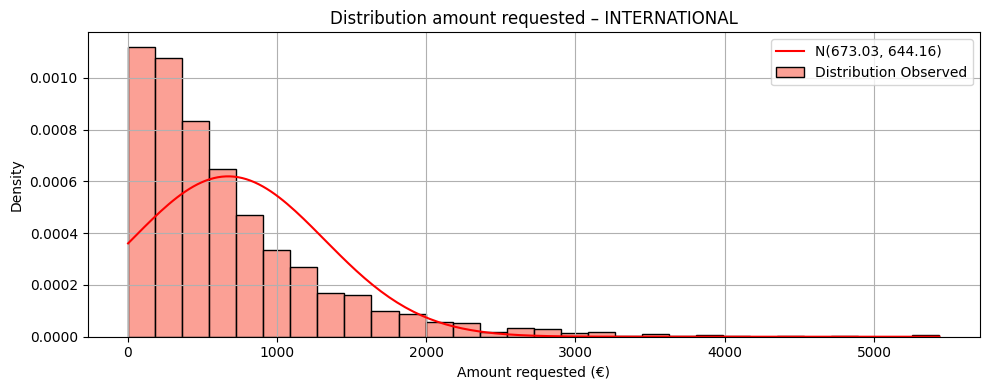

In [1682]:
# NORMALITY TEST INTERNATIONAL ON AMOUNT
sample_i = amounts_i
if len(amounts_i) > 500:
    sample_i = amounts_i.sample(500, random_state=42)

shapiro_stat_i, shapiro_p_i = shapiro(sample_i)
print(f"📊 INTERNATIONAL — Shapiro-Wilk p-value: {shapiro_p_i:.5f}")
if shapiro_p_i < 0.05:
    print("Distribution is NOT normal(p < 0.05)")
else:
    print("Distribution is normal (p ≥ 0.05)")

# Parametri per gaussiana teorica
mu_i = amounts_i.mean()
sigma_i = amounts_i.std()

# Grafico
plt.figure(figsize=(10, 4))
sns.histplot(amounts_i, stat="density", bins=30, color="salmon", label="Distribution Observed")
x_i = np.linspace(amounts_i.min(), amounts_i.max(), 200)
plt.plot(x_i, norm.pdf(x_i, mu_i, sigma_i), color="red", label=f"N({mu_i:.2f}, {sigma_i:.2f})")
plt.title("Distribution amount requested – INTERNATIONAL")
plt.xlabel("Amount requested (€)")
plt.ylabel("Density")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [1683]:
# Calcolo IQR e bound per INTERNATIONAL
q1_amount_i = amounts_i.quantile(0.25)
q3_amount_i = amounts_i.quantile(0.75)
iqr_amount_i = q3_amount_i - q1_amount_i
lower_i = q1_amount_i - 1.5 * iqr_amount_i
upper_i = q3_amount_i + 1.5 * iqr_amount_i
outliers_i = amounts_i[(amounts_i < lower_i) | (amounts_i > upper_i)]
print(f"INTERNATIONAL – Outlier Amount: {len(outliers_i)} su {len(amounts_i)} casi")

# Rimuovi outlier da INTERNATIONAL
outlier_ids_i = set(outliers_i.index)
filtered_internat_df = filtered_internat_df[
    ~filtered_internat_df["case:concept:name"].isin(outlier_ids_i)
]

truncated_internat_df = truncated_internat_df[
    ~truncated_internat_df["case:concept:name"].isin(outlier_ids_i)
]
print(f"INTERNATIONAL – Remaining cases (filtered): {filtered_internat_df['case:concept:name'].nunique()}")

INTERNATIONAL – Outlier Amount: 179 su 3318 casi
INTERNATIONAL – Remaining cases (filtered): 3139


In [1684]:
#recalculate lead time and activity counts for domestic log
lead_times_d = filtered_domestic_df.groupby("case:concept:name")["time:timestamp"] \
    .agg(lambda x: (x.max() - x.min()).total_seconds() / 86400)

# (case size)
activity_counts_d = filtered_domestic_df.groupby("case:concept:name")["concept:name"].count()

print("Mean lead time (days):", lead_times_d.mean())
print("Mean number of cases:", activity_counts_d.mean())


Mean lead time (days): 7.908146940174398
Mean number of cases: 5.111515641855448


In [1685]:
# #recalculate lead time and activity counts for international log
lead_times_i = truncated_internat_df.groupby("case:concept:name")["time:timestamp"] \
    .agg(lambda x: (x.max() - x.min()).total_seconds() / 86400)

#(case size)
activity_counts_i = truncated_internat_df.groupby("case:concept:name")["concept:name"].count()

print("Mean lead time (days):", lead_times_i.mean())
print("Mean number of cases:", activity_counts_i.mean())


Mean lead time (days): 10.014371305440516
Mean number of cases: 5.438356164383562


In [1686]:
#Amount analisys

#Mean Requested Amount – Domestic
amounts_d = filtered_domestic_df.groupby("case:concept:name")["case:Amount"].first()
mean_amount_d = amounts_d.mean()
print(f"RMean requested amount - Domestic log: {mean_amount_d:.2f}")

# 3. Calcolo importo medio richiesto per caso – International
amounts_i = truncated_internat_df.groupby("case:concept:name")["case:Amount"].first()
mean_amount_i = amounts_i.mean()
print(f"Mean Requested Amount – International log: {mean_amount_i:.2f}")


RMean requested amount - Domestic log: 47.95
Mean Requested Amount – International log: 564.89


In [1687]:
import matplotlib.pyplot as plt

# Calcolo delle medie
mean_lead_time_d = lead_times_d.mean()
mean_lead_time_i = lead_times_i.mean()

mean_activities_d = activity_counts_d.mean()
mean_activities_i = activity_counts_i.mean()



C:\Users\chiar\AppData\Local\Temp\ipykernel_66312\928078784.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Log Type", y="Lead Time (giorni)", data=df_plot, palette=["skyblue", "salmon"])
C:\Users\chiar\AppData\Local\Temp\ipykernel_66312\928078784.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="Log Type", y="Case Size (numero attività)", data=df_plot, palette=["skyblue", "salmon"])


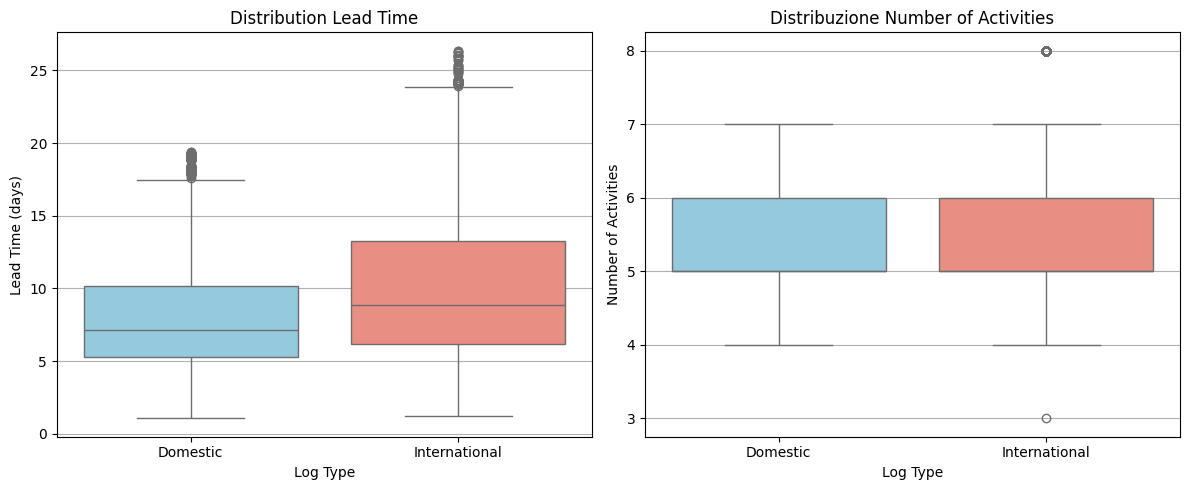

In [1689]:


# Crete dataframe for plotting confrontation
df_plot = pd.DataFrame({
    "Lead Time (giorni)": pd.concat([lead_times_d, lead_times_i], ignore_index=True),
    "Case Size (numero attività)": pd.concat([activity_counts_d, activity_counts_i], ignore_index=True),
    "Amount Requested": pd.concat([amounts_d, amounts_i], ignore_index=True),
    "Log Type": ["Domestic"] * len(lead_times_d) + ["International"] * len(lead_times_i)
})

# --- Plot Lead Time ---
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x="Log Type", y="Lead Time (giorni)", data=df_plot, palette=["skyblue", "salmon"])
plt.title("Distribution Lead Time")
plt.ylabel("Lead Time (days)")
plt.grid(True, axis='y')

# --- Plot Case Size ---
plt.subplot(1, 2, 2)
sns.boxplot(x="Log Type", y="Case Size (numero attività)", data=df_plot, palette=["skyblue", "salmon"])
plt.title("Distribuzione Number of Activities")
plt.ylabel("Number of Activities")
plt.grid(True, axis='y')




plt.tight_layout()
plt.show()


C:\Users\chiar\AppData\Local\Temp\ipykernel_66312\2763592916.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_amounts, x="Log", y="Importo richiesto (€)", palette=["skyblue", "salmon"], showfliers=False)
C:\Users\chiar\AppData\Local\Temp\ipykernel_66312\2763592916.py:17: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\chiar\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128230 (\N{PACKAGE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


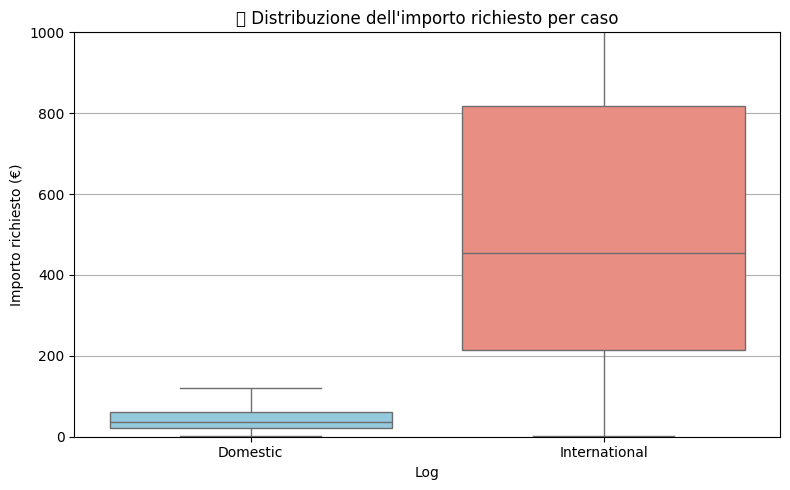

In [ ]:

amounts_domestic_clean = filtered_domestic_df.groupby("case:concept:name")["case:Amount"].first()
amounts_internat_clean = truncated_internat_df.groupby("case:concept:name")["case:Amount"].first()

# Crea un DataFrame unificato per il plot
df_amounts = pd.DataFrame({
    "Importo richiesto (€)": pd.concat([amounts_domestic_clean, amounts_internat_clean]),
    "Log": ["Domestic"] * len(amounts_domestic_clean) + ["International"] * len(amounts_internat_clean)
})

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(data=df_amounts, x="Log", y="Importo richiesto (€)", palette=["skyblue", "salmon"], showfliers=False)
plt.title("Distribuzione dell'importo richiesto per caso")
plt.grid(True, axis='y')
plt.ylim(0, 1000)  # Adatta se vuoi mostrare meglio i valori centrali
plt.tight_layout()
plt.show()

In [ ]:
from pm4py.statistics.variants.log import get as variants_module

# get top 5 variants for domestic log
representative_domestic_log = pm4py.filter_variants_top_k(
    filtered_domestic_df,
    k=5,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:concept:name'
)

#from pm4py.statistics.variants.log import get as variants_module


variants = variants_module.get_variants(representative_domestic_log)

for i, (variant, traces) in enumerate(sorted(variants.items(), key=lambda x: len(x[1]), reverse=True), start=1):
    print(f"{i}. {' ➝ '.join(variant)} — {len(traces)} casi")


1. Declaration SUBMITTED by EMPLOYEE ➝ Declaration APPROVED by ADMINISTRATION ➝ Declaration FINAL_APPROVED by SUPERVISOR ➝ Request Payment ➝ Payment Handled — 3856 casi
2. Declaration SUBMITTED by EMPLOYEE ➝ Declaration APPROVED by ADMINISTRATION ➝ Declaration APPROVED by BUDGET OWNER ➝ Declaration FINAL_APPROVED by SUPERVISOR ➝ Request Payment ➝ Payment Handled — 1892 casi
3. Declaration SUBMITTED by EMPLOYEE ➝ Declaration FINAL_APPROVED by SUPERVISOR ➝ Request Payment ➝ Payment Handled — 1135 casi
4. Declaration SUBMITTED by EMPLOYEE ➝ Declaration APPROVED by PRE_APPROVER ➝ Declaration FINAL_APPROVED by SUPERVISOR ➝ Request Payment ➝ Payment Handled — 495 casi
5. Declaration SUBMITTED by EMPLOYEE ➝ Declaration FINAL_APPROVED by SUPERVISOR ➝ Declaration REJECTED by MISSING ➝ Declaration SUBMITTED by EMPLOYEE ➝ Declaration FINAL_APPROVED by SUPERVISOR ➝ Request Payment ➝ Payment Handled — 19 casi


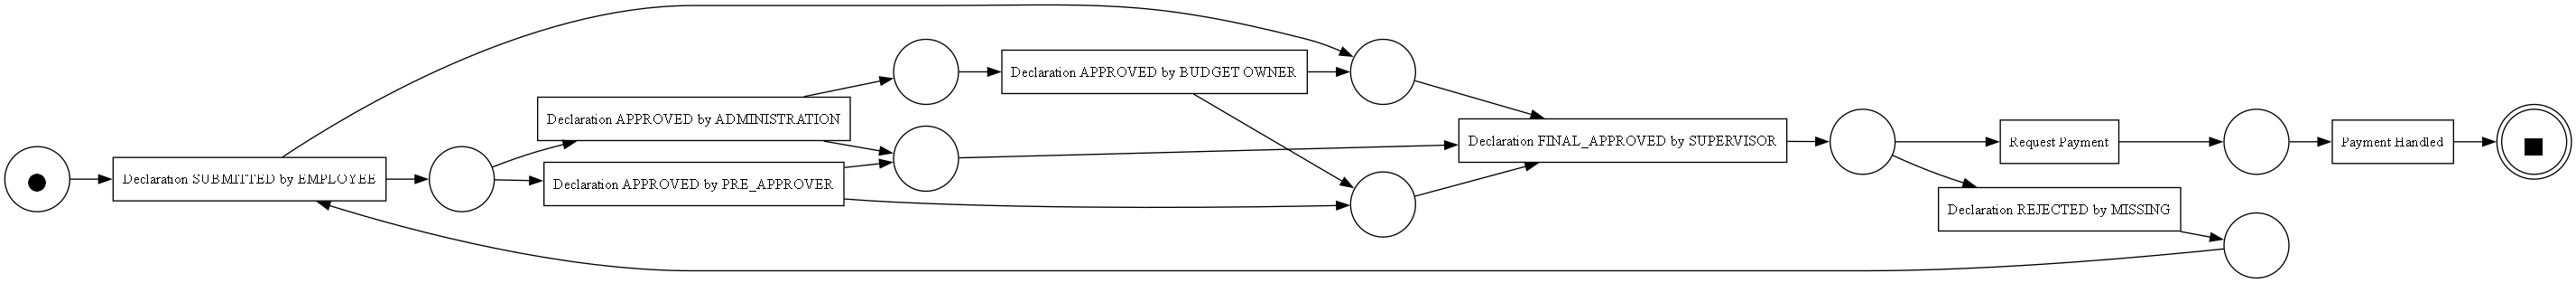

In [ ]:
net, im, fm = pm4py.discover_petri_net_alpha(representative_domestic_log)
pm4py.view_petri_net(net, im, fm, format='png')

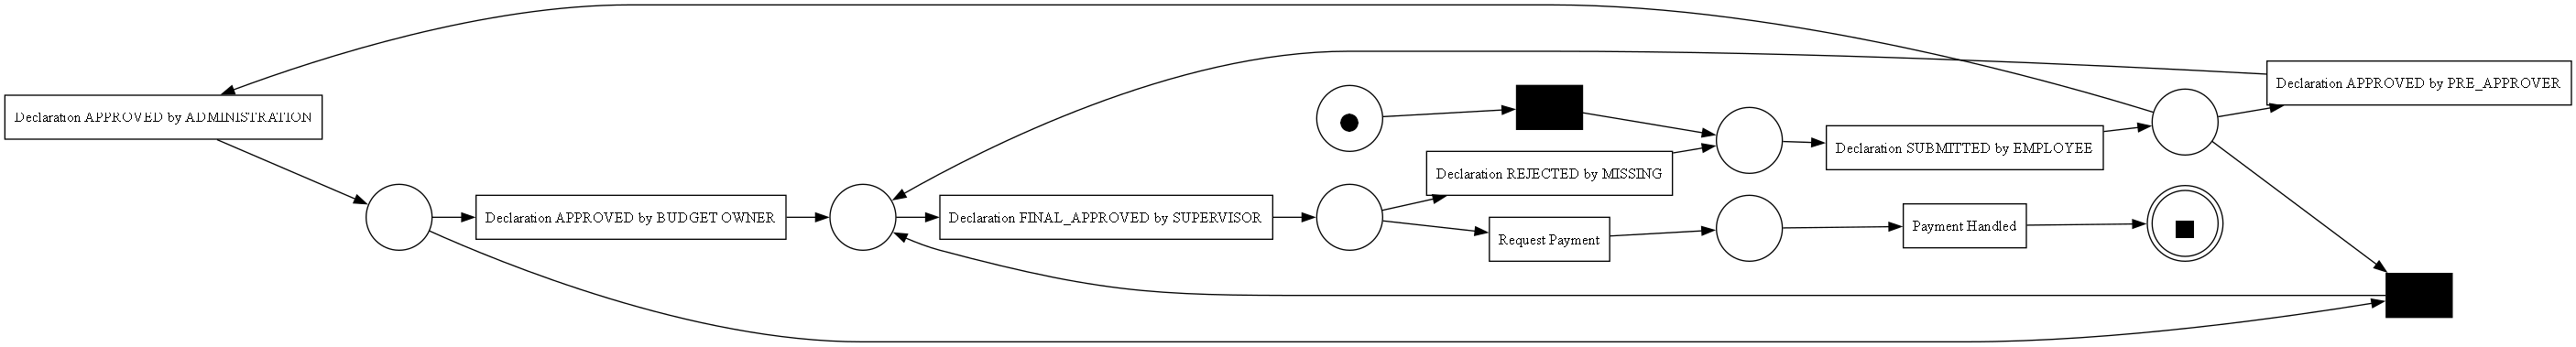

In [ ]:
# Discover the model with Heuristic Miner

net, im, fm = pm4py.discover_petri_net_heuristics(representative_domestic_log, dependency_threshold=0.9)
pm4py.view_petri_net(net, im, fm, format='png')

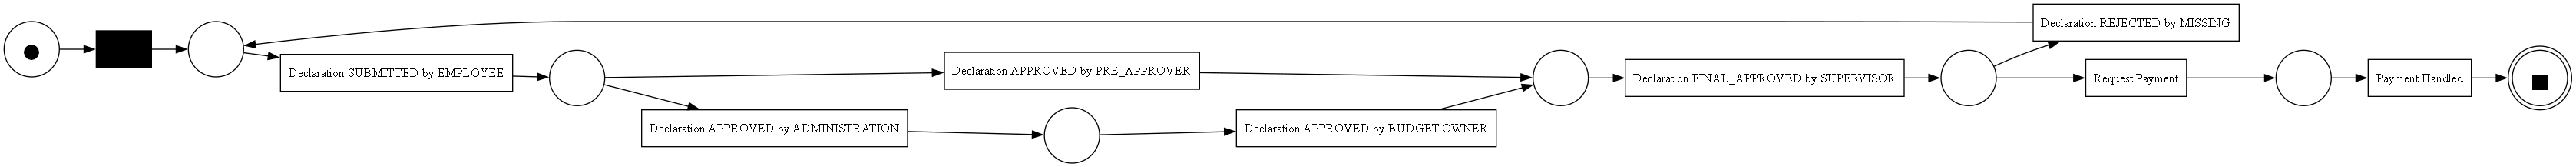

In [ ]:

# Discover the model with Inductive Miner

net, im, fm = pm4py.discover_petri_net_inductive(representative_domestic_log, noise_threshold=0.8)
pm4py.view_petri_net(net, im, fm, format='png')


In [ ]:

# Token-Based Conformance Checking
diagnostics_df_d = pm4py.conformance_diagnostics_token_based_replay(
    filtered_domestic_df,
    net,  
    im,
    fm,
    activity_key="concept:name",
    timestamp_key="time:timestamp",
    case_id_key="case:concept:name",
    return_diagnostics_dataframe=True  
)

# show first cases
diagnostics_df_d.head()

# count fit and unfit traces
total_traces = len(diagnostics_df_d)
fit_traces = diagnostics_df_d["is_fit"].sum()  # True = 1
unfit_traces = total_traces - fit_traces

# Percentage
perc_fit = (fit_traces / total_traces) * 100
perc_unfit = 100 - perc_fit

print(f"Conform traces: {fit_traces} on {total_traces} ({perc_fit:.2f}%)")
print(f"Non-conform traces: {unfit_traces} on {total_traces} ({perc_unfit:.2f}%)")



replaying log with TBR, completed traces :: 100%|██████████| 10/10 [00:00<00:00, 291.57it/s]

✅ Tracce conformi: 2387 su 7416 (32.19%)
❌ Tracce non conformi: 5029 su 7416 (67.81%)


In [ ]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as align_algo

# Esegui l'analisi di conformità (alignment-based)
aligned_traces = align_algo.apply_log(
    filtered_domestic_df,
    net,
    im,
    fm
)

# Calcola e stampa la fitness media
fitness_values = [trace["fitness"] for trace in aligned_traces if "fitness" in trace]
average_fitness = sum(fitness_values) / len(fitness_values)
print(f"Mean fitness (alignments): {average_fitness:.4f}")


aligning log, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 740.45it/s]

📊 Fitness media (alignments): 0.9296


In [ ]:
#recap
diagnostics = pm4py . conformance_diagnostics_alignments ( filtered_domestic_df , net
, im , fm , return_diagnostics_dataframe = True )

# Numero totale di casi
total = len(diagnostics)

# Numero di tracce conformi
fit = diagnostics['is_fit'].sum()

# Fitness media
mean_fitness = diagnostics['fitness'].mean()

print(f"Conform Traces: {fit}/{total} ({(fit/total)*100:.2f}%)")
print(f"Mean fitness: {mean_fitness:.4f}")

low_fit = diagnostics[diagnostics['fitness'] < 0.7]
low_fit.head()





aligning log, completed variants :: 100%|██████████| 10/10 [00:00<00:00, 839.48it/s]

✅ Tracce conformi: 2387/7416 (32.19%)
📊 Fitness media: 0.9296


,case_id,cost,fitness,is_fit
32,declaration 86604,40001,0.666667,False
52,declaration 90912,40001,0.666667,False
216,declaration 92510,40001,0.666667,False
231,declaration 86564,40001,0.666667,False
419,declaration 89961,40001,0.666667,False


In [ ]:

case_ids = filtered_domestic_df["case:concept:name"].unique()

# Get DataFrame with con alignment add fitness
aligned_df = pd.DataFrame([
    {
        "case:concept:name": case_ids[i],
        "fitness": trace.get("fitness", None),
        "alignment": trace.get("alignment", [])
    }
    for i, trace in enumerate(aligned_traces)
])


In [ ]:

diagnostics["case:concept:name"] = filtered_domestic_df["case:concept:name"].unique()

# order traces by fitness and get the worst 20
worst_20 = diagnostics.sort_values(by="fitness").head(20)


worst_20[["case:concept:name", "fitness"]]


,case:concept:name,fitness
7359,declaration 142979,0.272727
7397,declaration 132896,0.555556
1561,declaration 90815,0.600000
1177,declaration 96335,0.666667
957,declaration 92344,0.666667
1297,declaration 94464,0.666667
231,declaration 86564,0.666667
1201,declaration 90603,0.666667
828,declaration 95936,0.666667
619,declaration 90445,0.666667


C:\Users\chiar\AppData\Local\Temp\ipykernel_66312\1969550548.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


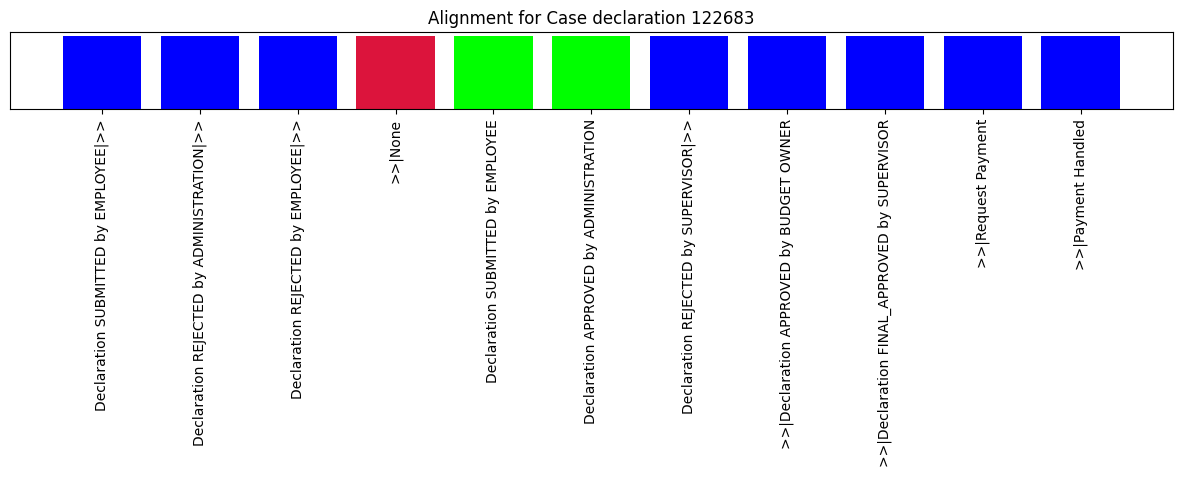

C:\Users\chiar\AppData\Local\Temp\ipykernel_66312\1969550548.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


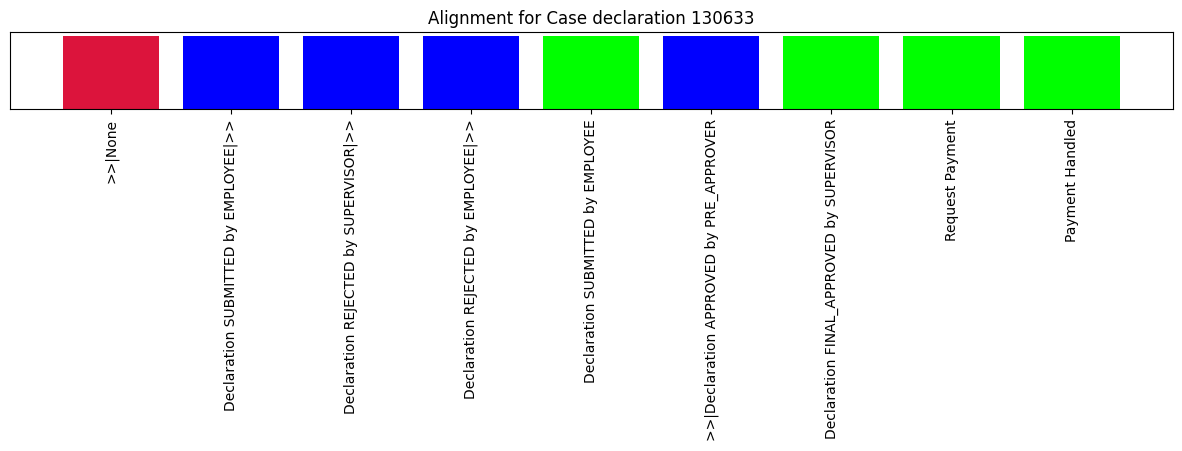

In [ ]:

worst_case = worst_20.iloc[0] 

import matplotlib.pyplot as plt

def plot_alignment(case_id, alignment):
    aligned = []
    labels = []

    for pair in alignment:
        if not isinstance(pair, (list, tuple)) or len(pair) < 2:
            continue
        log_act, model_act = pair[:2]

        if log_act == model_act:
            aligned.append(1)
            labels.append(log_act or model_act)
        else:
            aligned.append(1)
            labels.append(f'{log_act}|{model_act}')

    # Colors: green = sync, blue = model-only, red = log-only
    colors = []
    for lbl in labels:
        if '|' not in lbl:
            colors.append('lime')
        elif lbl.endswith('|None'):
            colors.append('crimson')  # log move
        elif lbl.startswith('None|'):
            colors.append('purple')     # model move
        else:
            colors.append('blue')     # altro (se capita)

    plt.figure(figsize=(15, 1))
    plt.bar(range(len(labels)), aligned, color=colors)
    plt.xticks(range(len(labels)), labels, rotation=90)
    plt.title(f"Alignment for Case {case_id}")
    plt.yticks([])
    plt.tight_layout()
    plt.show()

# take 20 worst
worst_20 = aligned_df.sort_values(by="fitness").head(20)

# take a single worst case and plot its alignment
worst_case = worst_20.iloc[0]
plot_alignment(worst_case["case:concept:name"], worst_case["alignment"])




In [ ]:
from pm4py.statistics.variants.log import get as variants_module

# Get top 5 variants for international log
representative_international_log = pm4py.filter_variants_top_k(
    filtered_internat_df,
    k=5,
    activity_key='concept:name',
    timestamp_key='time:timestamp',
    case_id_key='case:concept:name'
)

#from pm4py.statistics.variants.log import get as variants_module


variants = variants_module.get_variants(representative_international_log)

for i, (variant, traces) in enumerate(sorted(variants.items(), key=lambda x: len(x[1]), reverse=True), start=1):
    print(f"{i}. {' ➝ '.join(variant)} — {len(traces)} casi")


1. Permit SUBMITTED by EMPLOYEE ➝ Permit APPROVED by ADMINISTRATION ➝ Permit FINAL_APPROVED by SUPERVISOR ➝ Start trip ➝ End trip ➝ Declaration SUBMITTED by EMPLOYEE ➝ Declaration APPROVED by ADMINISTRATION ➝ Declaration FINAL_APPROVED by SUPERVISOR ➝ Request Payment ➝ Payment Handled — 1239 casi
2. Permit SUBMITTED by EMPLOYEE ➝ Permit APPROVED by ADMINISTRATION ➝ Permit APPROVED by BUDGET OWNER ➝ Permit FINAL_APPROVED by SUPERVISOR ➝ Start trip ➝ End trip ➝ Declaration SUBMITTED by EMPLOYEE ➝ Declaration APPROVED by ADMINISTRATION ➝ Declaration APPROVED by BUDGET OWNER ➝ Declaration FINAL_APPROVED by SUPERVISOR ➝ Request Payment ➝ Payment Handled — 542 casi
3. Permit SUBMITTED by EMPLOYEE ➝ Permit FINAL_APPROVED by SUPERVISOR ➝ Start trip ➝ End trip ➝ Declaration SUBMITTED by EMPLOYEE ➝ Declaration FINAL_APPROVED by SUPERVISOR ➝ Request Payment ➝ Payment Handled — 343 casi
4. Permit SUBMITTED by EMPLOYEE ➝ Permit APPROVED by ADMINISTRATION ➝ Permit FINAL_APPROVED by SUPERVISOR ➝ Star

c:\Users\chiar\AppData\Local\Programs\Python\Python313\Lib\site-packages\pm4py\algo\discovery\dfg\adapters\pandas\df_statistics.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[start_timestamp_key] = df[timestamp_key]


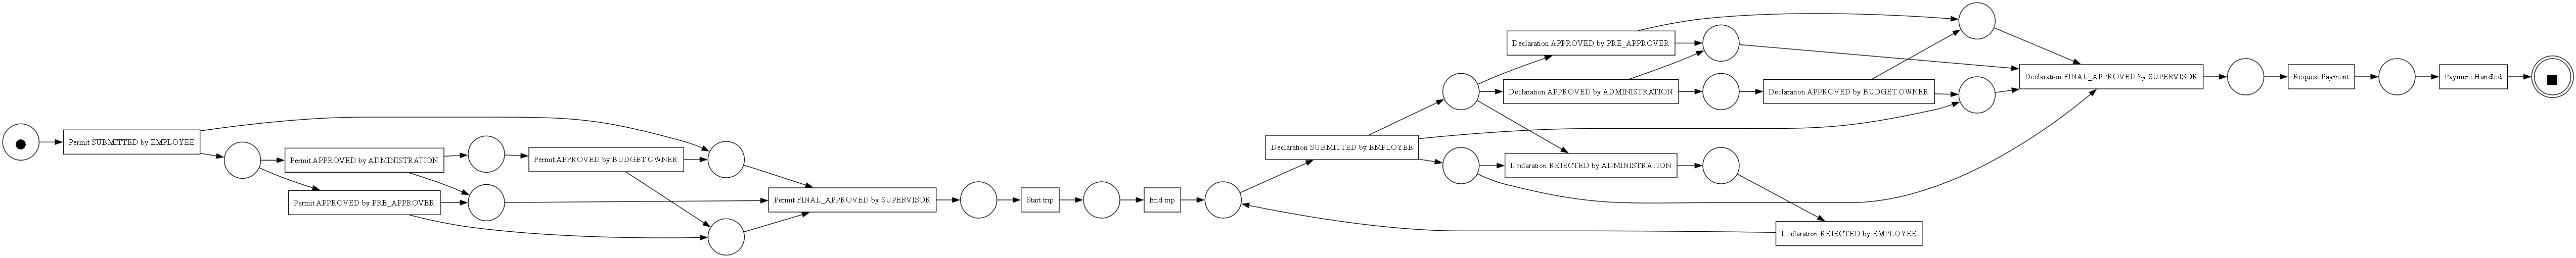

In [ ]:
net, im, fm = pm4py.discover_petri_net_alpha(representative_international_log)
pm4py.view_petri_net(net, im, fm, format='png')

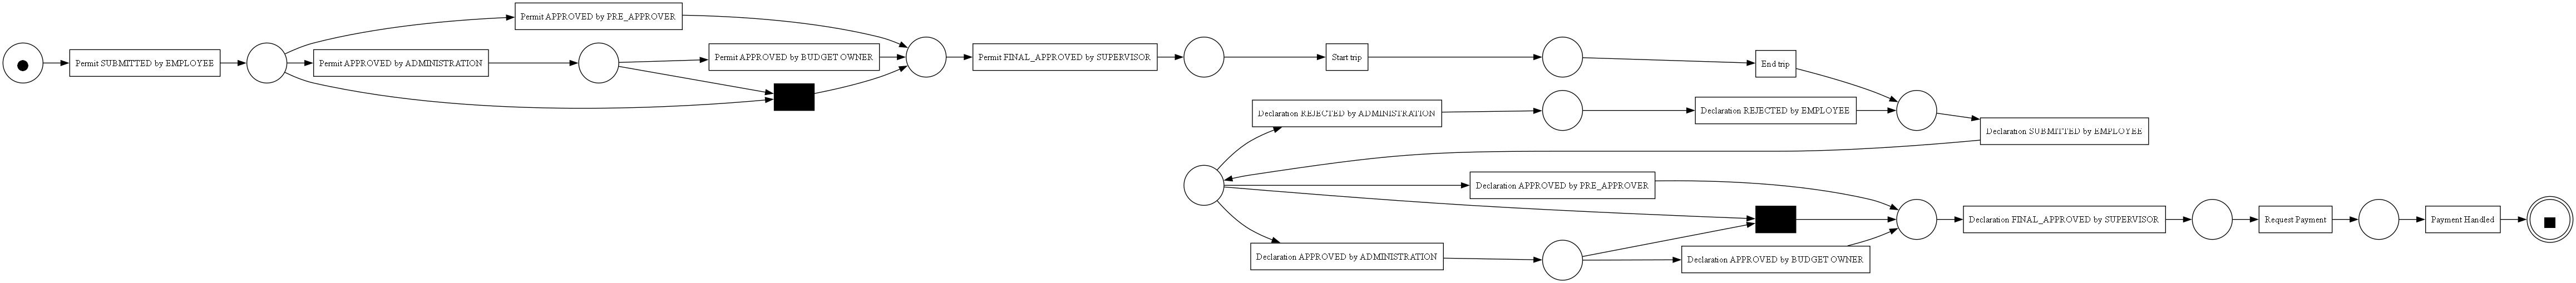

In [ ]:
# Discover the model with Heuristic Miner

net, im, fm = pm4py.discover_petri_net_heuristics(representative_international_log, dependency_threshold=0.8)
pm4py.view_petri_net(net, im, fm, format='png')

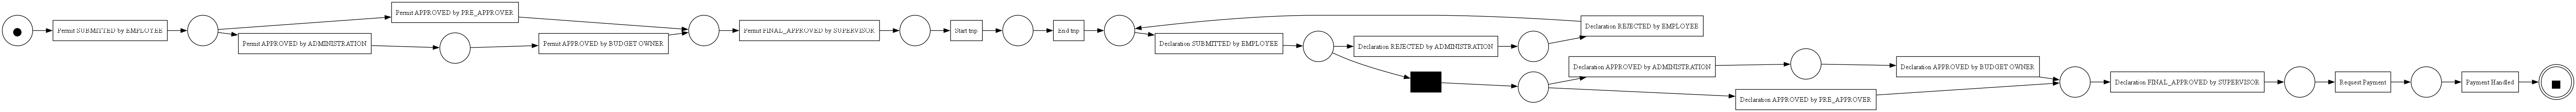

In [ ]:

# Discover the model with Inductive Miner

net, im, fm = pm4py.discover_petri_net_inductive(representative_international_log, noise_threshold=0.8)
pm4py.view_petri_net(net, im, fm, format='png')

In [ ]:

# Token-Based Conformance Checking
diagnostics_df_i = pm4py.conformance_diagnostics_token_based_replay(
    filtered_internat_df,
    net,  # la rete di Petri ottenuta dal discovery
    im,
    fm,
    activity_key="concept:name",
    timestamp_key="time:timestamp",
    case_id_key="case:concept:name",
    return_diagnostics_dataframe=True  # così ottieni un DataFrame
)

# Mostra i primi risultati
diagnostics_df_i.head()

# Conteggio tracce conformi e non conformi
total_traces = len(diagnostics_df_i)
fit_traces = diagnostics_df_i["is_fit"].sum()  # True = 1
unfit_traces = total_traces - fit_traces

# Percentuali
perc_fit = (fit_traces / total_traces) * 100
perc_unfit = 100 - perc_fit

print(f"Conform traces: {fit_traces} on {total_traces} ({perc_fit:.2f}%)")
print(f"Non conform traces: {unfit_traces} on {total_traces} ({perc_unfit:.2f}%)")

replaying log with TBR, completed traces :: 100%|██████████| 93/93 [00:00<00:00, 2090.57it/s]

✅ Tracce conformi: 817 su 3139 (26.03%)
❌ Tracce non conformi: 2322 su 3139 (73.97%)


In [ ]:
from pm4py.algo.conformance.alignments.petri_net import algorithm as align_algo

# conformity analysis (alignment-based)
aligned_traces_i = align_algo.apply_log(
    filtered_internat_df,
    net,
    im,
    fm
)

#mean fitness
fitness_values_i = [trace["fitness"] for trace in aligned_traces_i if "fitness" in trace]
average_fitness_i = sum(fitness_values) / len(fitness_values)
print(f"📊 Fitness media (alignments): {average_fitness:.4f}")

aligning log, completed variants :: 100%|██████████| 93/93 [00:00<00:00, 398.73it/s]

📊 Fitness media (alignments): 0.9296


In [ ]:

diagnostics_i = pm4py . conformance_diagnostics_alignments ( filtered_internat_df , net
, im , fm , return_diagnostics_dataframe = True )


total_i = len(diagnostics_i)

# Number of fit traces
fit_i = diagnostics_i['is_fit'].sum()

# Fitness mean
mean_fitness_i = diagnostics_i['fitness'].mean()

print(f"Conform traces: {fit_i}/{total_i} ({(fit_i/total_i)*100:.2f}%)")
print(f"Mean Fitness: {mean_fitness_i:.4f}")

low_fit_i = diagnostics_i[diagnostics_i['fitness'] < 0.7]
low_fit_i.head()





aligning log, completed variants :: 100%|██████████| 93/93 [00:00<00:00, 283.19it/s]

✅ Tracce conformi: 771/3139 (24.56%)
📊 Fitness media: 0.9209


,case_id,cost,fitness,is_fit
441,declaration 82172,80001,0.666667,False
551,declaration 84067,80001,0.666667,False
3137,declaration 27616,60001,0.666667,False


In [ ]:

case_ids_i = filtered_internat_df["case:concept:name"].unique()

aligned_df = pd.DataFrame([
    {
        "case:concept:name": case_ids_i[i],
        "fitness": trace.get("fitness", None),
        "alignment": trace.get("alignment", [])
    }
    for i, trace in enumerate(aligned_traces_i)
])


In [ ]:

diagnostics_i["case:concept:name"] = filtered_internat_df["case:concept:name"].unique()


worst_20_i = diagnostics_i.sort_values(by="fitness").head(20)

worst_20[["case:concept:name", "fitness"]]


,case:concept:name,fitness
5280,declaration 122683,0.272727
4019,declaration 112496,0.555556
6012,declaration 141488,0.600000
6694,declaration 133253,0.666667
6637,declaration 132127,0.666667
6944,declaration 133490,0.666667
5884,declaration 130633,0.666667
5333,declaration 128651,0.666667
6030,declaration 133524,0.666667
5957,declaration 136625,0.666667


C:\Users\chiar\AppData\Local\Temp\ipykernel_66312\1969550548.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


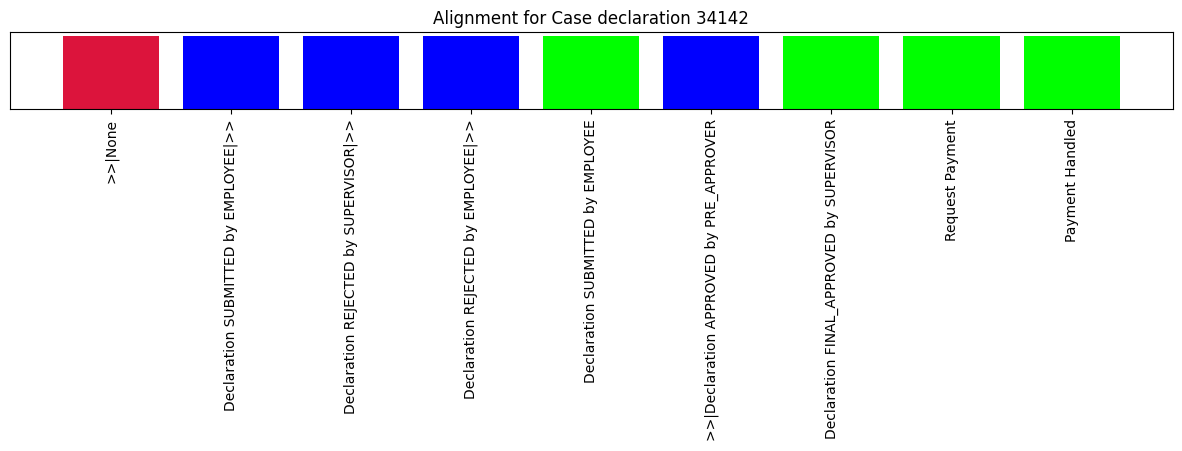

C:\Users\chiar\AppData\Local\Temp\ipykernel_66312\1969550548.py:39: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


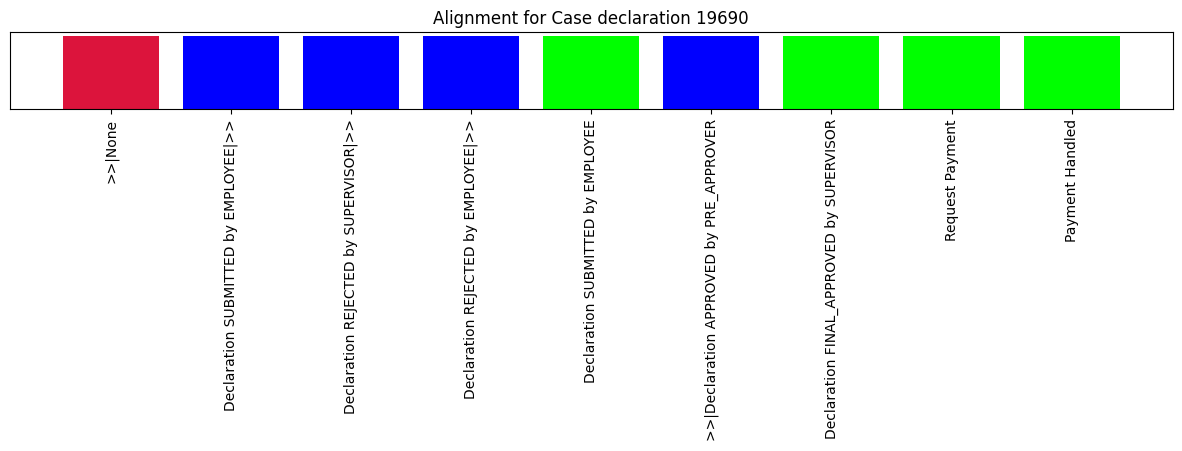

In [ ]:

# get 20 worst cases
worst_20 = aligned_df.sort_values(by="fitness").head(20)

# get one of the cases
worst_case_i = worst_20.iloc[0]
plot_alignment(worst_case_i["case:concept:name"], worst_case["alignment"])



# plot the alignment of the worst case
plot_alignment(worst_case_i["case:concept:name"], worst_case["alignment"])
